In [1]:
import numpy as np
import torch
from torch import nn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS:
# for loading
LOAD_PATH_ENC = f"checkpoints/encoder/"
LOAD_EPOCH_ENC = 149
LOAD_PATH_LSTM = f"checkpoints/lstm/"
LOAD_EPOCH_LSTM = 3

# for map
MAP_NAME = '8x12_map_cropped'
DATASET = '60000_paths'
MAP_SHAPE = (64,64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# DEFINE DATASET LOADER:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu', stop_after=500):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        x = torch.tensor([]) # empty list to hold input series tensors
        num_paths = 0
        for filename in tqdm(os.listdir(path_dir)):
            num_paths += 1
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                path_points_list = [] # a list to hold each point in a path
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                for point in self.path:
                    x = point[0]
                    y = point[1]
                    this_point = [x, y]
                    path_points_list.append(this_point)
            sequence = torch.tensor(path_points_list, dtype=torch.float)[:, :]
            self.paths.append(sequence)

            if num_paths == stop_after:
                break
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        return path

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = self.paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [4]:
# DEFINE ENCODER STRUCTURE:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [5]:
# DEFINE LSTM STRUCTURE:
class MyLSTM(nn.Module):
  # hidden_d - the size of the hidden LSTM layers
  # map_d - the flattened/encoded map dimension
  def __init__(self, hidden_d=120, map_d=128, device="cpu"):
    self.hidden_d = hidden_d
    self.device = device
    super(MyLSTM, self).__init__()

    # map hidden layer
    self.lstm_map = nn.LSTMCell(input_size=map_d, hidden_size=self.hidden_d, device=self.device)

    # points hidden layer
    self.lstm_points = nn.LSTMCell(input_size=4, hidden_size=self.hidden_d, device=self.device)
    
    # "upper" hidden layer
    self.lstm1 = nn.LSTMCell(input_size=self.hidden_d*2, hidden_size=self.hidden_d, device=self.device)
    self.fc = nn.Linear(self.hidden_d, 2, device=self.device)


  def forward(self, goal_point, current_point, map):

    # Creation of cell state and hidden state for map hidden layer
    hidden_state_map = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_map = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for points hidden layer
    hidden_state_points = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_points = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for "upper" hidden layer
    hidden_state_1 = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_1 = torch.zeros(1, self.hidden_d).to(self.device)

    outputs = []

    # initialize weights to random[-0.1, 0.1) (need to update initialzation to match paper)
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state_map)
    torch.nn.init.xavier_normal_(cell_state_map)

    torch.nn.init.xavier_normal_(hidden_state_points)
    torch.nn.init.xavier_normal_(cell_state_points)

    torch.nn.init.xavier_normal_(hidden_state_1)
    torch.nn.init.xavier_normal_(cell_state_1)

    # Concatenate start and goal
    points = torch.cat([current_point, goal_point], 0).unsqueeze(0)

    hidden_state_map, cell_state_map = self.lstm_map(map, (hidden_state_map, cell_state_map))
    hidden_state_points, cell_state_points = self.lstm_points(points, (hidden_state_points, cell_state_points))

    # Concatenate the output the lstm layer output from points and map into a single input to the final "upper" hidden layer
    final_layer_input = torch.cat([hidden_state_map, hidden_state_points], 1)
    hidden_state_1, cell_state_1 = self.lstm1(final_layer_input, (hidden_state_1, cell_state_1))
      
    # Last hidden state is passed through a fully connected neural net
    output = self.fc(hidden_state_1)	
    outputs.append(output)

    outputs = torch.cat(outputs, dim=0)
    
    return outputs

In [6]:
# CREATE ENCODER INSTANCE:
encoder = Encoder()

# CREATE LSTM INSTANCE:
rnn = MyLSTM(device=device)

In [7]:
# LOAD ENCODER:
checkpoint = torch.load(f'{LOAD_PATH_ENC}epoch-{LOAD_EPOCH_ENC}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])
encoder.to(device)
encoder.eval()

# LOAD LSTM:
checkpoint = torch.load(f'{LOAD_PATH_LSTM}epoch-{LOAD_EPOCH_LSTM}.tar')
rnn.load_state_dict(checkpoint['model_state_dict'])
rnn.to(device)
rnn.eval()

MyLSTM(
  (lstm_map): LSTMCell(128, 120)
  (lstm_points): LSTMCell(4, 120)
  (lstm1): LSTMCell(240, 120)
  (fc): Linear(in_features=120, out_features=2, bias=True)
)

In [8]:
# LOAD AND ENCODE MAP:
flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file

map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)

In [9]:
# LOAD PATHS:
paths_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/{DATASET}/training", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=None, device=device, stop_after=1000)

  2%|▏         | 999/59687 [00:00<00:16, 3508.83it/s]

Done!


In [10]:
# testing to see if it follows paths used for training:

num_points = 30 # num points to predict for each path
NUM_SAMPLES = 10 # num training paths to plot
EXAMPLE_OFFSET = 10
generated_paths = []

for path_idx in range(EXAMPLE_OFFSET, EXAMPLE_OFFSET+NUM_SAMPLES):
    start_point = paths_dataset[path_idx][0].to(device)
    goal_point = paths_dataset[path_idx][len(paths_dataset[path_idx])-1].to(device)
    generated_pts = []
    with torch.no_grad():
        # add start point:
        generated_pts.append(start_point.cpu().detach().numpy().tolist())
        prev_pred = start_point

        # predict other points:
        for i in range(num_points):
            pred = rnn(goal_point, prev_pred, encoded_map).squeeze()
            prev_pred = pred
            generated_pts.append(pred.cpu().detach().numpy().tolist())

    generated_paths.append(generated_pts)

    xs = []
    ys = []

    for x,y in generated_pts:
        xs.append(x)
        ys.append(y)

    # plt.imshow(map.cpu())
    # plt.plot(xs, ys, color='b', label = "predicted")
    # plt.plot(paths_dataset[path_idx][:,0], paths_dataset[path_idx][:,1], color='r', label = "truth", linestyle='dashed')
    # plt.scatter(goal_point[0].cpu(), goal_point[1].cpu())
    # plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    # plt.legend()
    # plt.show()

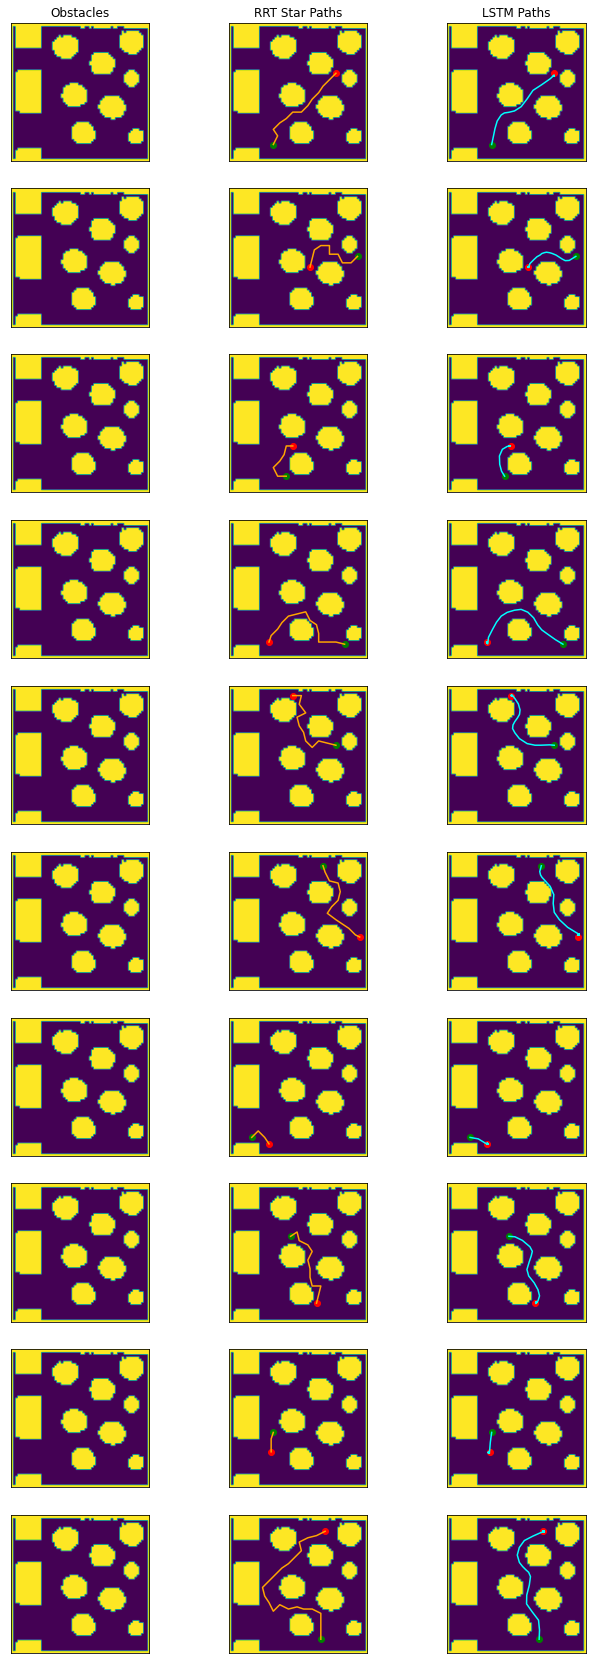

In [11]:
fig = plt.figure(figsize=(15,30))
fig.set_facecolor('white')

col_title = True
for i in range(EXAMPLE_OFFSET, EXAMPLE_OFFSET+NUM_SAMPLES):

    start_point = paths_dataset[i][0]
    goal_point = paths_dataset[i][len(paths_dataset[i])-1]

    xs = []
    ys = []
    for x,y in generated_paths[i-EXAMPLE_OFFSET]:
        xs.append(x)
        ys.append(y)

    sub = fig.add_subplot(NUM_SAMPLES,4,(i-EXAMPLE_OFFSET)*4+1)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    if col_title:
        plt.title('Obstacles')

    sub = fig.add_subplot(NUM_SAMPLES,4,(i-EXAMPLE_OFFSET)*4+2)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    # plot truth path
    plt.plot(paths_dataset[i][:,0], paths_dataset[i][:,1], color='orange')
    plt.scatter(goal_point[0], goal_point[1], color="r")
    plt.scatter(start_point[0], start_point[1], color="g")
    if col_title:
        plt.title('RRT Star Paths')

    sub = fig.add_subplot(NUM_SAMPLES,4,(i-EXAMPLE_OFFSET)*4+3)
    sub.set_xticks([])
    sub.set_yticks([])
    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='aqua', label = "predicted")
    plt.scatter(goal_point[0], goal_point[1], color="r")
    plt.scatter(start_point[0], start_point[1], color="g")
    if col_title:
        plt.title('LSTM Paths')

    col_title = False

plt.savefig("output.png", facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()